# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [204]:
# Dependencies and Setup
%matplotlib notebook

from ipywidgets.embed import embed_minimal_html
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import json
import os

# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [71]:
data = pd.read_csv('../WeatherPy/output_data/cities.csv')

### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [14]:
# Configure gmaps with API key
gmaps.configure(api_key=g_key)

In [54]:
# Store 'Lat' and 'Lng' into  locations 
locations = list(zip(data.Lat, data.Lng))

humidity = data["Humidity"].astype(float).values.tolist()

In [56]:
print(type(locations))
print(type(humidity))

print(len(locations))
print(len(humidity))

<class 'list'>
<class 'list'>
550
550


In [65]:
# Create a humidity Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=humidity, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 3)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [66]:
# Export to html
#embed_minimal_html('output_html/humidity_heatmap_3point.html', views=[fig])

<img src="output_img/snap.jpg" />

In [184]:
# Get lower and upper quartiles
humidity_by_country = data.groupby("Country").mean().reset_index()
humidity_by_country

humidity_quartiles = humidity_by_country["Humidity"].quantile([.25,.75])
lowerq = humidity_quartiles[0.25]
upperq = humidity_quartiles[0.75]

<IPython.core.display.Javascript object>


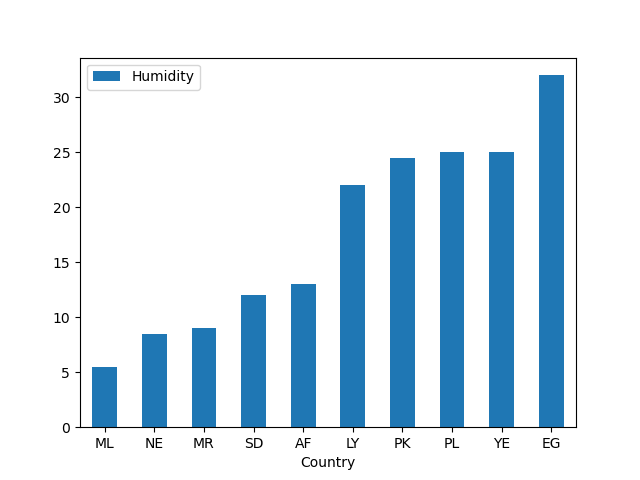

In [215]:
# Plot lower quartile
lower_humidity_by_country = humidity_by_country.loc[humidity_by_country["Humidity"] <= lowerq]

lower_humidity_by_country = lower_humidity_by_country.sort_values(by="Humidity", ascending=True)
lower_humidity_by_country = lower_humidity_by_country[:10]

ax = lower_humidity_by_country.plot.bar(x='Country', y='Humidity', rot=0)

<IPython.core.display.Javascript object>


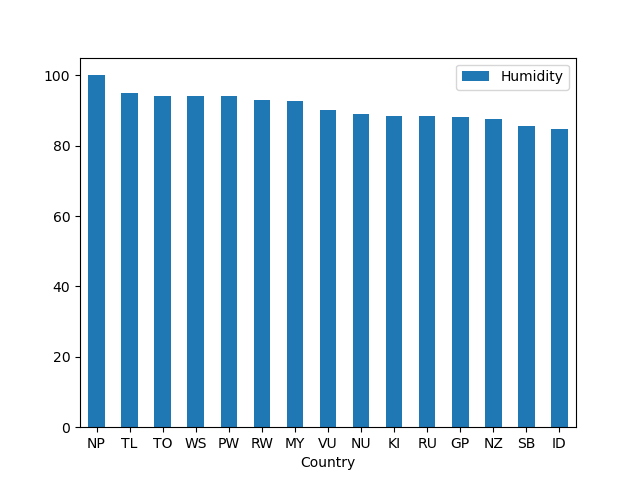

In [218]:
# Plot upper quartile
upper_humidity_by_country = humidity_by_country.loc[humidity_by_country["Humidity"] >= upperq]

upper_humidity_by_country = upper_humidity_by_country.sort_values(by="Humidity", ascending=False)
upper_humidity_by_country = upper_humidity_by_country[:15]

ax = upper_humidity_by_country.plot.bar(x='Country', y='Humidity', rot=0)

<h3>Observable trends</h3>

<ul>
    <li>Humidity increase in all world cities in the coast</li>
    <li>There are more humidity in cities near water like lakes or rivers</li>
    <li>Today the countries more drier are Mali, Niger, Mauritania, Sudan and Afghanistan</li>
</ul>
<img src="output_img/Humidity_5point.png" />
<hr>

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [85]:
# Espeficing weather conditions
lower_limit = 64
upper_limit = 86

lower_humidity = 40
upper_humidity = 70

lower_wind = 10
upper_wind = 15

upper_cloud = 60

cities_selected = data.loc[ \
    (data["Min Temp"] >= lower_limit) & (data["Max Temp"] <= upper_limit) \
    & (data["Humidity"] >= lower_humidity) & (data["Humidity"] <= upper_humidity) \
    & (data["Wind Speed"] >= lower_wind) & (data["Wind Speed"] <= upper_wind) \
    & (data["Cloudiness"] <= upper_cloud)]
cities_selected.dropna(inplace=True)
cities_selected

C:\Users\Wayssen\anaconda3\envs\pythonData\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,City,Lat,Lng,Max Temp,Min Temp,Humidity,Cloudiness,Wind Speed,Country,Date
78,78,Cidreira,-30.1811,-50.2056,73.76,73.76,56,7,14.81,BR,1617210483
141,141,Chui,-33.6971,-53.4616,71.56,71.56,55,26,11.41,UY,1617210516
150,150,Arraial do Cabo,-22.9661,-42.0278,82.40,82.40,65,0,14.97,BR,1617210520
185,185,Ambovombe,-25.1667,46.0833,70.90,70.90,69,24,11.54,MG,1617210437
209,209,Rio Grande,-32.0350,-52.0986,77.00,77.00,53,40,13.80,BR,1617210482
273,273,Sidi Ali,36.0998,0.4206,71.71,71.71,44,0,12.28,DZ,1617210580
363,363,Betioky,-23.7167,44.3833,72.86,72.86,52,0,13.06,MG,1617210626
368,368,Coquimbo,-29.9533,-71.3436,64.40,64.40,68,20,13.80,CL,1617210629
381,381,Isla Mujeres,21.2311,-86.7310,86.00,81.00,58,20,13.80,MX,1617210635
426,426,Umluj,25.0213,37.2685,71.76,71.76,54,2,12.35,SA,1617210656


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [169]:
# base url
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

hotel_df = pd.DataFrame(columns=['Lat', 'Lng', 'Country', 'Hotel Name', 'Vicinity'])
for index, city in cities_selected.iterrows():

    # set up a parameters dictionary
    params = {
        "location": f"{city['Lat']}, {city['Lng']}",
        "keyword": "hotel",
        "radius": 5000,
        "type": "hotel",
        "rankby": "prominence",
        "key": g_key
    }

    try:
        # run a request using our params dictionary
        response = requests.get(base_url, params=params)
                
        # convert response to json
        places_data = response.json()
                
        hotel_df = hotel_df.append(pd.DataFrame.from_dict({
            "Lat" : [city['Lat']],
            "Lng": [city['Lng']],
            "Country": [city['Country']],
            "Hotel Name" : [places_data["results"][0]["name"]],
            "Vicinity" : [places_data["results"][0]["vicinity"]]
        }))
    except Exception as e:
        print(f"Probably has not been places found for city: {city[1]}")
        print(e)


Probably has not been places found for city: Sidi Ali
list index out of range
Probably has not been places found for city: Betioky
list index out of range
Probably has not been places found for city: Montevideo
list index out of range
Probably has not been places found for city: Lluta
list index out of range


In [170]:
hotel_df = hotel_df.reset_index()
hotel_df.head(60)

,index,Lat,Lng,Country,Hotel Name,Vicinity
0,0,-30.1811,-50.2056,BR,Hotel Castelo,"R. Osvaldo Aranha, 3968 - CIDREIRA, Cidreira"
1,0,-33.6971,-53.4616,UY,Descanso al Paso Chuy,"AVENIDA ESPAÑA 552, Magallanes CASI, Chuy"
2,0,-22.9661,-42.0278,BR,Orlanova Boutique Hotel,"Av. Roberto Silveira, 2 - Praia dos Anjos, Arr..."
3,0,-25.1667,46.0833,MG,Hotel Le Source,Ambovombe
4,0,-32.0350,-52.0986,BR,Laghetto Viverone Rio Grande,"R. Aquidaban, 703 - Centro, Rio Grande"
5,0,-29.9533,-71.3436,CL,Hotel San Juan,Coquimbo
6,0,21.2311,-86.7310,MX,"Nomads Hotel, Hostel & Beach Club",Carretera Garrafon KM 4.5
7,0,25.0213,37.2685,SA,HP Red Sea Hotel,طريق الملك عبدالله،، Umluj


In [171]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>Country</dt><dd>{Country}</dd>
<dt>Vicinity</dt><dd>{Vicinity}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [172]:
# Add marker layer ontop of heat map

fig = gmaps.figure()
markers = gmaps.marker_layer(locations,
    info_box_content=hotel_info)
fig.add_layer(markers)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

<img src="output_img/snap2.jpg" />

<h2>Finally the perfect weather could be in:</h2>
<h3>
    <ul>
        <li>Isla mujeres, an Island near Cancun Mexico</li>
        <li>The south of the Island of Madagascar</li>
        <li>Arraial do Cabo, a coastal town in the state of Rio de Janeiro Brazil</li>
    </ul>
</h3>